In [1]:
import numpy as np
import wandb
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , accuracy_score
from scipy.special import log_softmax,softmax
import seaborn as sns

In [2]:
class FFNN:
    def __init__(self,net_size,layer_act,init_wb='random',lr=1e-3,opt='rmsprop',lamda=0,batch_size=64,\
                 n_epochs=10,gamma=0.9,beta=0.999,beta_1=0.9,beta_2=0.999,seed=None,loss='cross_ent',relu_param=0,epsilon=1e-8):
        
        self.net_size = net_size
        self.layer_acts = layer_act
        self.init_wb = init_wb
        self.lr = lr
        self.optim = opt
        self.lamda = lamda
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.loss = loss
        self.seed = seed
        self.relu_param=relu_param
        self.gamma = gamma
        self.beta=beta
        self.epsilon=epsilon

    def onehot_encode(self,y, n_labels):
        mat = np.zeros((len(y), n_labels))
        for i, val in enumerate(y):
            mat[i, val] = 1
        return mat.T
    
    def nn_init(self, network_size, wb_init='random'):

        if self.seed is not None:
            np.random.seed(self.seed)

        params = {}

        num_layers = len(network_size)

        if wb_init == 'random':
            for layer in range(1, num_layers):
                params['weights' + str(layer)] = np.random.normal(0,1,(network_size[layer], network_size[layer - 1]))
                params['biases' + str(layer)] = np.random.normal(0,1,(network_size[layer], 1))
                
        elif wb_init == 'xavier_uniform':
            for layer in range(1, num_layers):
                r = np.sqrt(6.0 / (network_size[layer] + network_size[layer - 1]))
                params['weights' + str(layer)] = np.random.uniform(-r, r, (network_size[layer], network_size[layer - 1]))
                params['biases' + str(layer)] = np.random.uniform(-r, r, (network_size[layer], 1))
        
        else:
            raise ValueError('Invalid Activation function ...')
        return params
    
    def Linear(self,input_data,diff=False):
        input_data = np.array(input_data, dtype=np.float64)
        if diff == False:
            return input_data
        else:
            return np.ones_like(input_data)

    def ReLU(self, input_data, diff=False):
        alpha = self.relu_param
        input_data = np.array(input_data, dtype=np.float64)

        if diff == False:
            return np.where(input_data < 0, alpha * input_data, input_data)

        elif diff == True:
            output_data = np.ones_like(input_data, dtype=np.float64)
            output_data[input_data < 0] = alpha
            return output_data
    
    # def ELU(self,input_data,diff=False):
    #     alpha = self.relu_param
    #     input_data = np.where(input_data>700,700,input_data)
    #     if diff == False:
    #         return np.where(input_data < 0, alpha * (np.exp(input_data)-1), input_data)
    #     else:
    #         output_data = np.ones_like(input_data, dtype=np.float64)
    #         output_data[input_data < 0] = alpha*np.exp(input_data)
    #         return output_data  
    
    def sigmoid(self, input_data, diff=False):
        input_data = np.where(input_data<-700,-700,input_data)
        if not diff:
            output_data = 1 / (1 + np.exp(-np.array(input_data)))
        else:
            s = 1 / (1 + np.exp(-np.array(input_data)))
            output_data = s * (1 - s)
        return output_data

    def Tanh(self, input_data, diff=False):
        input_data = np.array(input_data)
        input_data = np.clip(input_data,-700,700)
        if not diff:
            output_data = np.tanh(input_data)
        else:
            output_data = 1 - np.tanh(input_data) ** 2
        return output_data
    
    def softmax(self,X):
        X = np.clip(X,-700,700)
        return log_softmax(X,axis=0)

    def forward(self,data,acts,params):
        if self.seed is not None:
            np.random.seed(self.seed)
        param_list = []
        act_out = data
        for idx, act in enumerate(acts,start=1):
            data_prev = act_out
            Wb = np.dot(params['weights'+str(idx)],data_prev)+params['biases'+str(idx)]

            if act == 'sigmoid':
                act_out = self.sigmoid(Wb)
            elif act == 'tanh':
                act_out = self.Tanh(Wb)
            elif act == 'relu':
                act_out = self.ReLU(Wb)
            elif act == 'softmax':
                act_out = self.softmax(Wb)
            elif act == 'identity':
                act_out = self.Linear(Wb)
            # elif act == 'elu':
            #     act_out == self.ELU(Wb)
            else:
                raise ValueError('Invalid activation function ...')
            
            pl = ((data_prev,params['weights'+str(idx)],params['biases'+str(idx)]),Wb)
            param_list.append(pl)
        return act_out,param_list
    
    def grad(self,pred,target,params,lamda=0,loss='cross_ent'):
        n_class = target.shape[1]
        if loss == 'cross_ent':
            loss = -np.mean(np.multiply(pred,target),axis=1).sum()
        elif loss=='mse':
            loss = -np.mean(np.multiply(pred-target,pred-target),axis=1).sum()
        else:
            raise ValueError('Error function invalid. Please choose either "cross_ent" or "mse" ')
        param_len = len(params)//2

        sum_w = 0
        for idx in range(1,param_len):
            sum_w += np.square(params['weights'+str(idx)]).sum()
        loss += sum_w*(lamda/(2*n_class))
        return loss

    def backward(self,pred,target,param_list,acts,lamda=0,loss='cross_ent'):
        grad_tape = {}
        lpl = len(param_list)
        m,n = pred.shape
        target = target.reshape(pred.shape)
        if loss == 'cross_ent':
            dOut = np.exp(pred) - target
        elif loss == 'mse':
            dOut = 2*(np.exp(pred) - target)
        else:
            raise ValueError('Error function invalid. Please choose either "cross_ent" or "mse" ')

        pred,weight,_ = param_list[-1][0]
        grad_tape['d_weights'+str(lpl)] = np.dot(dOut,pred.T)/m
        grad_tape['d_biases'+str(lpl)] = dOut.sum(axis=1,keepdims=True)/m
        grad_tape['d_pred'+str(lpl-1)] = np.dot(weight.T,dOut)

        for idx in reversed(range(lpl-1)):
            linear_pred,out = param_list[idx]
            out_prev,weight,b = linear_pred

            m,n = out_prev.shape
            dOut_prev = grad_tape['d_pred'+str(idx+1)]

            if acts[idx] == 'relu':
                dOut = dOut_prev*self.ReLU(out,True)
            elif acts[idx] == 'sigmoid':
                dOut = dOut_prev*self.sigmoid(out,True)
            elif acts[idx] == 'tanh':
                dOut = dOut_prev*self.Tanh(out,True)
            # elif acts[idx] == 'elu':
            #     dOut = dOut_prev*self.ELU(out,True)
            elif acts[idx] == 'identity':
                dOut = dOut_prev*self.Linear(out,True)            
            
            grad_tape['d_pred'+str(idx)] = np.dot(weight.T,dOut)
            grad_tape['d_weights'+str(idx+1)] = (np.dot(dOut,out_prev.T)+ lamda*weight)/m
            grad_tape['d_biases'+str(idx+1)] = dOut.sum(axis=1,keepdims=True)/m
        return grad_tape
        

    def optim_step(self,params,grad_tape,lr,t_step,algo='adam',moment_params=None):
        len_param = len(params)//2

        if algo == 'sgd':
            for idx in range(len_param):
                params['weights'+str(idx+1)] -= lr*grad_tape['d_weights'+str(idx+1)]
                params['biases'+str(idx+1)] -= lr*grad_tape['d_biases'+str(idx+1)]
                moment_params=None
        elif algo == 'sgdm':
            for idx in range(len_param):
                moment_params['v_w'+str(idx+1)] = self.gamma*moment_params['v_w'+str(idx+1)] + (1-self.gamma)*grad_tape['d_weights'+str(idx+1)]
                moment_params['v_b'+str(idx+1)] = self.gamma*moment_params['v_b'+str(idx+1)] + (1-self.gamma)*grad_tape['d_biases'+str(idx+1)]

                params['weights'+str(idx+1)] -= lr*moment_params['v_w'+str(idx+1)]
                params['biases'+str(idx+1)] -= lr*moment_params['v_b'+str(idx+1)]
        elif algo == 'nag':
            for idx in range(len_param):
                moment_params['v_w'+str(idx+1)] = self.gamma*moment_params['v_w'+str(idx+1)] - lr*grad_tape['d_weights'+str(idx+1)]
                moment_params['v_b'+str(idx+1)] = self.gamma*moment_params['v_b'+str(idx+1)] - lr*grad_tape['d_biases'+str(idx+1)]

                params['weights'+str(idx+1)] -= self.gamma*(moment_params['v_w'+str(idx+1)] - moment_params['v_w_prev'+str(idx+1)])
                params['biases'+str(idx+1)] -= self.gamma*(moment_params['v_b'+str(idx+1)] - moment_params['v_b_prev'+str(idx+1)])

                moment_params['v_w_prev'+str(idx+1)] = moment_params['v_w'+str(idx+1)]
                moment_params['v_b_prev'+str(idx+1)] = moment_params['v_b'+str(idx+1)]

        elif algo == 'rmsprop':
            for idx in range(len_param):
                moment_params['m_b'+str(idx+1)] = self.beta*moment_params['m_b'+str(idx+1)] + (1-self.beta)*(grad_tape['d_biases'+str(idx+1)]**2)
                moment_params['m_w'+str(idx+1)] = self.beta*moment_params['m_w'+str(idx+1)] + (1-self.beta)*(grad_tape['d_weights'+str(idx+1)]**2)

                params['weights'+str(idx+1)] -= lr*grad_tape['d_weights'+str(idx+1)]/(np.sqrt(moment_params['m_w'+str(idx+1)])+self.epsilon)
                params['biases'+str(idx+1)] -= lr*grad_tape['d_biases'+str(idx+1)]/(np.sqrt(moment_params['m_b'+str(idx+1)])+self.epsilon)

        elif algo == 'adam':
            for idx in range(len_param):
                moment_params['v_b'+str(idx+1)] = self.beta_1*moment_params['v_b'+str(idx+1)] + (1-self.beta_1)*grad_tape['d_biases'+str(idx+1)]
                moment_params['v_w'+str(idx+1)] = self.beta_1*moment_params['v_w'+str(idx+1)] + (1-self.beta_1)*grad_tape['d_weights'+str(idx+1)]

                moment_params['m_b'+str(idx+1)] = self.beta_2*moment_params['m_b'+str(idx+1)] + (1-self.beta_2)*(grad_tape['d_biases'+str(idx+1)]**2)
                moment_params['m_w'+str(idx+1)] = self.beta_2*moment_params['m_w'+str(idx+1)] + (1-self.beta_2)*(grad_tape['d_weights'+str(idx+1)]**2)

                mod_lr = lr*np.sqrt((1-self.beta_2**t_step)/(1-self.beta_1**t_step+self.epsilon))
                params['weights'+str(idx+1)] -= mod_lr*(moment_params['v_w'+str(idx+1)]/(np.sqrt(moment_params['m_w'+str(idx+1)])+self.epsilon))
                params['biases'+str(idx+1)] -= mod_lr*(moment_params['v_b'+str(idx+1)]/(np.sqrt(moment_params['m_b'+str(idx+1)])+self.epsilon))
        elif algo =='nadam':
            for idx in range(len_param):
                moment_params['v_b'+str(idx+1)] = self.beta_1*moment_params['v_b'+str(idx+1)] + (1-self.beta_1)*grad_tape['d_biases'+str(idx+1)]
                moment_params['v_w'+str(idx+1)] = self.beta_1*moment_params['v_w'+str(idx+1)] + (1-self.beta_1)*grad_tape['d_weights'+str(idx+1)]

                moment_params['m_b'+str(idx+1)] = self.beta_2*moment_params['m_b'+str(idx+1)] + (1-self.beta_2)*(grad_tape['d_biases'+str(idx+1)]**2)
                moment_params['m_w'+str(idx+1)] = self.beta_2*moment_params['m_w'+str(idx+1)] + (1-self.beta_2)*(grad_tape['d_weights'+str(idx+1)]**2)

                mod_lr = lr*np.sqrt((1-self.beta_2**t_step)/(1-self.beta_1**t_step+self.epsilon))
                params['weights'+str(idx+1)] -= (mod_lr/(np.sqrt(moment_params['m_w'+str(idx+1)])+self.epsilon))*(self.beta_1*moment_params['v_w'+str(idx+1)] + (1-self.beta_1)*grad_tape['d_weights'+str(idx+1)])
                params['biases'+str(idx+1)] -= (mod_lr/(np.sqrt(moment_params['m_b'+str(idx+1)])+self.epsilon))*(self.beta_1*moment_params['v_b'+str(idx+1)] + (1-self.beta_1)*grad_tape['d_biases'+str(idx+1)])
        return params,moment_params
    
    def predict(self,data):
        out = self.forward(data,self.layer_acts,self.params)[0]
        return np.argmax(out,axis=0),out.T
    
    def train(self,X_train,Y_train,X_val,Y_val,n_classes=10,wb_log=True):
        self.losses=[]
        moment_params = {}
        m = X_train.shape[1]
        y_train = self.onehot_encode(Y_train,n_classes)
        y_val = self.onehot_encode(Y_val,n_classes)
        self.params = self.nn_init(self.net_size,self.init_wb)
        self.t_step = 1
        idx = np.arange(m)

        if self.optim != 'sgd':
            for ii in range(1,len(self.net_size)):
                moment_params['v_w'+str(ii)] = np.zeros((self.net_size[ii],self.net_size[ii-1]))
                moment_params['v_b'+str(ii)] = np.zeros((self.net_size[ii],1))

                moment_params['v_w_prev'+str(ii)] = np.zeros((self.net_size[ii],self.net_size[ii-1]))
                moment_params['v_b_prev'+str(ii)] = np.zeros((self.net_size[ii],1))

                moment_params['m_w'+str(ii)] = np.zeros((self.net_size[ii],self.net_size[ii-1]))
                moment_params['m_b'+str(ii)] = np.zeros((self.net_size[ii],1))
        
        for _ in range(self.n_epochs):
            np.random.shuffle(idx)
            X_shuffled = X_train[:,idx]
            Y_shuffled = y_train[:,idx]
            for ii in range(0,m,self.batch_size):
                X_batched = X_shuffled[:,ii:ii+self.batch_size]
                Y_batched = Y_shuffled[:,ii:ii+self.batch_size]

                out,param_list = self.forward(X_batched,self.layer_acts,self.params)                
                loss = self.grad(out,Y_batched,self.params,self.lamda,self.loss)                
                self.losses.append(loss)
                grads = self.backward(out,Y_batched,param_list,self.layer_acts,self.lamda,self.loss)
                self.params,moment_params = self.optim_step(self.params,grads,self.lr,\
                                                            self.t_step,self.optim,moment_params)
                self.t_step+=1
            y_pred_train,_ = self.predict(X_train)
            y_pred_valid,_ = self.predict(X_val)

            train_acc = accuracy_score(Y_train,y_pred_train)
            val_acc = accuracy_score(Y_val,y_pred_valid)
            val_out,_ = self.forward(X_val,self.layer_acts,self.params)
            val_loss = self.grad(val_out,y_val,self.params,self.lamda,self.loss)
            log = {'train_acc':train_acc, 'val_acc':val_acc,'train_loss':loss,'val_loss':val_loss}#
            if wb_log:
                wandb.log(log)
            else:
                print(log)

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress',
               'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

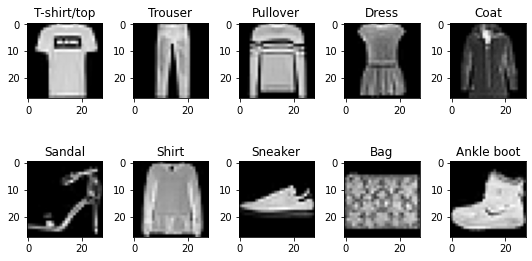

In [4]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

class_num = 10
num_row = 2
num_col = 5# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
img_list=[]
for i in range(class_num):
  ax = axes[i//num_col, i%num_col]
  a = np.argmax(y_train == i)
  ax.imshow(x_train[a], cmap='gray')
  ax.set_title(class_names[i])
plt.tight_layout()

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=0, stratify=y_train)

x_train = x_train.reshape((len(x_train), 28*28))
x_train = x_train.astype('float32') / 255

x_valid = x_valid.reshape((len(x_valid), 28*28))
x_valid = x_valid.astype('float32') / 255

# Preprocessing test data
x_test = x_test.reshape((len(x_test), 28 * 28))
x_test = x_test.astype('float32') / 225

In [5]:
X = x_train.T
X_valid = x_valid.T
Y_valid = y_valid
Y = y_train
n_class= 10
n_hidden = 4
layers = []
hidden_size=32
for i in range(n_hidden+2):
    if i == 0:
        layers.append(X.shape[0])
    elif i == n_hidden+1:
        layers.append(n_class)
    else:
        layers.append(hidden_size)
    i = i+1
act = []
o_act = 'softmax'
actvn_fn = 'identity'
for i in range(n_hidden+1):
    if i == n_hidden:
        act.append(o_act)
    else:
        act.append(actvn_fn)
    i = i+1
model = FFNN(layers,act,'xavier_uniform',opt='adam')

In [6]:
# model.params = model.nn_init(layers)
# model.train(X,Y,X_valid,Y_valid,wb_log=False)
# y_pred,_ = model.predict(x_test.T)

In [7]:
sweep_config = {
    'method':'bayes',
    'metric':{
    'name':'val_acc',
    'goal':'maximize'
    },
    'parameters':{
    'n_epochs':{
    'values':[5,10]
    },
    'n_hidden':{
    'values':[3,4,5]
    },
    'n_hidden_units':{
    'values':[32,64,128]
    },
    'l2_coeff':{
    'values':[0,5e-4,5e-1]
    },
    'lr':{
    'values':[1e-3,1e-4]
    },
    'optim_algo':{
    'values':['sgd','sgdm','rmsprop','adam','nadam','nag']
    },
    'batch_size':{
    'values':[16,32,64]
    },
    'weights_init':{
    'values':['random','xavier_uniform']
    },
    'act_func':{
    'values':['relu','sigmoid','tanh','identity']
    },
    'loss_func':{
    'values':['cross_ent','mse']
    },
    'relu_param':{
    'values':[0,1e-1,1e-2,1e-3]
    }
    }
}


In [8]:
sweep_id = wandb.sweep(sweep_config, entity="viswa_ee", project="CS6910")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: t38ec2il
Sweep URL: https://wandb.ai/viswa_ee/CS6910/sweeps/t38ec2il


In [9]:
def learn():
    config_defaults={
        'n_epochs':10,
        'n_hidden':3,
        'n_hidden_units':10,
        'l2_coeff':0,
        'lr':1e-3,
        'optim_algo':'sgd',
        'batch_size':16,
        'weights_init':'random',
        'act_func':'relu',
        'loss_func':'cross_ent',
        'relu_param':0
    }
    wandb.init(config=config_defaults)
    config = wandb.config
    X = x_train.T
    X_valid = x_valid.T
    Y_valid = y_valid
    Y = y_train
    n_class= 10
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress',
               'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    layers = []
    for i in range(config.n_hidden+2):
        if i == 0:
            layers.append(X.shape[0])
        elif i == config.n_hidden+1:
            layers.append(n_class)
        else:
            layers.append(config.n_hidden_units)
        i = i+1
    
    output_act = 'softmax'
    act_fn = config.act_func

    acts = []
    for i in range(config.n_hidden+1):
        if i == config.n_hidden:
            acts.append(output_act)
        else:
            acts.append(act_fn)
        i = i+1
    
    wandb.run.name = config.weights_init+'_'+ config.optim_algo +'_'+ config.act_func + '_bs_' + str(config.batch_size)+'_layers_'+str(config.n_hidden)+'_neurons_'+str(config.n_hidden_units)
    model = FFNN(net_size=layers,layer_act=acts,init_wb=config.weights_init,lr=config.lr,opt=config.optim_algo,\
                 lamda=config.l2_coeff,batch_size=config.batch_size,n_epochs=config.n_epochs,loss=config.loss_func,relu_param=config.relu_param)
    model.train(X,Y,X_valid,Y_valid)
    y_test_pred,_ = model.predict(x_test.T)
    cm = confusion_matrix(y_test, y_test_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(
        cm_norm, annot=True, cmap="Blues", square=True, xticklabels=class_names, yticklabels=class_names
    )
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    # Log the confusion matrix plot to wandb
    wandb.log({"Confusion Matrix":wandb.Image(fig)})
    fig.clf()
    plt.close('all')
    # log = {'conf_matrix':wandb.plot.confusion_matrix(y_true=y_test,preds=y_test_pred,class_names=class_names)}
    # wandb.log(log)
    # wandb.log({'conf_mat_'+wandb.run.name:wandb.plot.confusion_matrix(y_true=y_test,preds=y_test_pred,class_names=class_names)})
    

In [10]:
wandb.agent(sweep_id,learn,count=60)

wandb: Agent Starting Run: fzfrooec with config:
wandb: 	act_func: sigmoid
wandb: 	batch_size: 32
wandb: 	l2_coeff: 0.0005
wandb: 	loss_func: cross_ent
wandb: 	lr: 0.001
wandb: 	n_epochs: 5
wandb: 	n_hidden: 4
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: nadam
wandb: 	relu_param: 0.1
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: viswa_ee. Use `wandb login --relogin` to force relogin


train_acc,▁▃▅▇█
train_loss,█▃▁▂▂
val_acc,▁▃▅▇█
val_loss,█▅▄▂▁
train_acc,0.87009
train_loss,1.99813
val_acc,0.8415
val_loss,0.42736


wandb: Agent Starting Run: 3tqzz0bg with config:
wandb: 	act_func: relu
wandb: 	batch_size: 16
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: cross_ent
wandb: 	lr: 0.0001
wandb: 	n_epochs: 5
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 32
wandb: 	optim_algo: sgdm
wandb: 	relu_param: 0.01
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▄▄▆█
train_loss,█▆▄▃▁
val_acc,▁▄▄▆█
val_loss,█▄▂▂▁
train_acc,0.40839
train_loss,446.14658
val_acc,0.40683
val_loss,3.48961


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ryr0qvka with config:
wandb: 	act_func: sigmoid
wandb: 	batch_size: 16
wandb: 	l2_coeff: 0
wandb: 	loss_func: cross_ent
wandb: 	lr: 0.0001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 32
wandb: 	optim_algo: sgdm
wandb: 	relu_param: 0.01
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▁▃▂▅▅▅▆▇█
train_loss,█▄▄▂▁▂▁▂▂▁
val_acc,▁▁▃▃▅▅▆▆▇█
val_loss,█▃▂▁▁▁▁▁▁▁
train_acc,0.14407
train_loss,2.17282
val_acc,0.13533
val_loss,2.26596


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yse2y36k with config:
wandb: 	act_func: tanh
wandb: 	batch_size: 32
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: mse
wandb: 	lr: 0.0001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 4
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: adam
wandb: 	relu_param: 0.1
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▃▅▅▆▇▇▇██
train_loss,▆█▇▅▃▄▃▂▁▅
val_acc,▁▃▅▅▆▇▇▇██
val_loss,█▆▃▂▂▁▁▂▂▃
train_acc,0.6115
train_loss,-2021.40866
val_acc,0.58167
val_loss,-4199.50913


wandb: Agent Starting Run: i5asbkj8 with config:
wandb: 	act_func: sigmoid
wandb: 	batch_size: 32
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: cross_ent
wandb: 	lr: 0.001
wandb: 	n_epochs: 5
wandb: 	n_hidden: 4
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: nadam
wandb: 	relu_param: 0.1
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,█▅▁▁▅
train_loss,█▁▁▁▁
val_acc,█▅▁▁▅
val_loss,█▁▃▂▁
train_acc,0.7272
train_loss,2.40916
val_acc,0.72217
val_loss,0.82921


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hd71eqxc with config:
wandb: 	act_func: sigmoid
wandb: 	batch_size: 32
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: mse
wandb: 	lr: 0.001
wandb: 	n_epochs: 5
wandb: 	n_hidden: 3
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: nag
wandb: 	relu_param: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▁█▁▁
train_loss,▂█▂▁▁
val_acc,▁▁█▁▁
val_loss,▁▁█▂▂
train_acc,0.09981
train_loss,-976.34544
val_acc,0.09933
val_loss,-2830.4906


wandb: Agent Starting Run: 3nv1sseo with config:
wandb: 	act_func: sigmoid
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: cross_ent
wandb: 	lr: 0.0001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 4
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: adam
wandb: 	relu_param: 0.1
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▄▅▆▇▇▇███
train_loss,█▇▆▅▄▃▃▂▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▇▅▅▄▃▂▂▁▁
train_acc,0.78641
train_loss,206.73745
val_acc,0.78033
val_loss,2.27829


wandb: Agent Starting Run: r9n263cv with config:
wandb: 	act_func: tanh
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: cross_ent
wandb: 	lr: 0.001
wandb: 	n_epochs: 5
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: adam
wandb: 	relu_param: 0.1
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▃▄▆█
train_loss,█▆▅▃▁
val_acc,▁▃▄▆█
val_loss,█▅▃▂▁
train_acc,0.67585
train_loss,407.38811
val_acc,0.64767
val_loss,4.23407


wandb: Agent Starting Run: z0m2wnzr with config:
wandb: 	act_func: sigmoid
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: mse
wandb: 	lr: 0.001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 4
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: adam
wandb: 	relu_param: 0.01
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▄██▅▂▇▇▄▅
train_loss,█▃▃▂▁▂▁▂▂▁
val_acc,▁▄█▇▅▃▇▇▅▅
val_loss,█▄▄▄▄▃▂▃▁▁
train_acc,0.8057
train_loss,-433.29369
val_acc,0.79833
val_loss,-438.28026


wandb: Agent Starting Run: t90zhy68 with config:
wandb: 	act_func: identity
wandb: 	batch_size: 32
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: cross_ent
wandb: 	lr: 0.0001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: nadam
wandb: 	relu_param: 0.1
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,█▆▃▄▄▂▁▂▂▅
train_loss,▁▁▂▂▃▄▅▆▇█
val_acc,█▆▃▄▄▂▁▁▂▅
val_loss,▃▁▁▁▇▁▇█▃▃
train_acc,0.21315
train_loss,8575.22736
val_acc,0.21283
val_loss,84.72727


wandb: Agent Starting Run: 4yqjbcb0 with config:
wandb: 	act_func: sigmoid
wandb: 	batch_size: 32
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: mse
wandb: 	lr: 0.0001
wandb: 	n_epochs: 5
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: nadam
wandb: 	relu_param: 0.1
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▄▆▇█
train_loss,█▆▄▂▁
val_acc,▁▄▆██
val_loss,█▅▄▂▁
train_acc,0.78133
train_loss,337.42605
val_acc,0.7765
val_loss,-316.23361


wandb: Agent Starting Run: ad6m2t0g with config:
wandb: 	act_func: tanh
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: mse
wandb: 	lr: 0.001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 4
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: adam
wandb: 	relu_param: 0.01
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▂▃▄▅▆▆▇██
train_loss,▁▃▅█▆▆██▆█
val_acc,▁▂▃▄▅▆▆▇██
val_loss,▁▂▄▅▆▇▇███
train_acc,0.82611
train_loss,-1152.59679
val_acc,0.81267
val_loss,-1267.9448


wandb: Agent Starting Run: j4mnw1f4 with config:
wandb: 	act_func: identity
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: mse
wandb: 	lr: 0.0001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 4
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: rmsprop
wandb: 	relu_param: 0.001
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,██▇▆▄▃▂▂▂▁
train_loss,▂▁▃▄▅▅▇█▆▇
val_acc,██▇▆▅▃▂▂▂▁
val_loss,▁▁▂▄▅▆▇▇▇█
train_acc,0.18074
train_loss,-9942758.90022
val_acc,0.17467
val_loss,-9787283.97125


wandb: Agent Starting Run: oiy7xdy7 with config:
wandb: 	act_func: sigmoid
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.0005
wandb: 	loss_func: cross_ent
wandb: 	lr: 0.001
wandb: 	n_epochs: 5
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: nadam
wandb: 	relu_param: 0.01
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▄▆▇█
train_loss,▆█▂▁▅
val_acc,▁▄▆▇█
val_loss,█▅▃▂▁
train_acc,0.85746
train_loss,1.37263
val_acc,0.837
val_loss,0.46324


wandb: Agent Starting Run: 2hr7m023 with config:
wandb: 	act_func: sigmoid
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: cross_ent
wandb: 	lr: 0.001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: nadam
wandb: 	relu_param: 0.01
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▇█▄▄▂▂▂▁▃
train_loss,█▃▂▁▁▁▁▁▁▁
val_acc,▁▇█▄▅▁▃▃▁▃
val_loss,█▃▁▁▁▁▁▁▁▁
train_acc,0.77439
train_loss,1.88442
val_acc,0.76933
val_loss,0.68775


wandb: Agent Starting Run: erjm6j7j with config:
wandb: 	act_func: sigmoid
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.0005
wandb: 	loss_func: mse
wandb: 	lr: 0.001
wandb: 	n_epochs: 5
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: nadam
wandb: 	relu_param: 0.01
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▅▆▇█
train_loss,██▅▆▁
val_acc,▁▅▇██
val_loss,█▆▅▄▁
train_acc,0.85178
train_loss,-783.05506
val_acc,0.83283
val_loss,-753.99753


wandb: Agent Starting Run: nxrbc2i6 with config:
wandb: 	act_func: sigmoid
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: mse
wandb: 	lr: 0.001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: nadam
wandb: 	relu_param: 0.01
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁█▅▇▆▇▃▅▆▆
train_loss,█▄▃▄▃▃▃▂▁▂
val_acc,▁█▆█▇█▅▅▇▇
val_loss,█▅▄▆▅▄▃▂▁▁
train_acc,0.8205
train_loss,-439.03495
val_acc,0.8185
val_loss,-484.39333


wandb: Agent Starting Run: oq6mcmal with config:
wandb: 	act_func: sigmoid
wandb: 	batch_size: 32
wandb: 	l2_coeff: 0.0005
wandb: 	loss_func: mse
wandb: 	lr: 0.001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: nadam
wandb: 	relu_param: 0.1
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▃▅▅▆▆▇▇██
train_loss,█▇▆▇▆▅▅▁▄▁
val_acc,▁▂▅▆▇▆▇▇██
val_loss,█▇▆▆▅▅▄▃▃▁
train_acc,0.89224
train_loss,-1176.29666
val_acc,0.85233
val_loss,-1075.94337


wandb: Agent Starting Run: 0e8q8n8f with config:
wandb: 	act_func: relu
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: cross_ent
wandb: 	lr: 0.001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: nag
wandb: 	relu_param: 0.1
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁
train_acc,0.1
train_loss,nan
val_acc,0.1
val_loss,nan


wandb: Agent Starting Run: 4sl0leqs with config:
wandb: 	act_func: sigmoid
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: mse
wandb: 	lr: 0.001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: adam
wandb: 	relu_param: 0.001
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▅█▇▆▆█▇▃▆
train_loss,█▄▄▄▄▃▃▃▂▁
val_acc,▁▆▇▇▇▆▇█▄▆
val_loss,▄▂▅█▇▆▅▃▁▁
train_acc,0.80706
train_loss,-489.20109
val_acc,0.80233
val_loss,-457.83495


wandb: Agent Starting Run: itt9by1y with config:
wandb: 	act_func: tanh
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.0005
wandb: 	loss_func: mse
wandb: 	lr: 0.001
wandb: 	n_epochs: 5
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: nadam
wandb: 	relu_param: 0.001
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▄▅▆█
train_loss,▁▁▃▆█
val_acc,▁▄▅▆█
val_loss,▁▂▄▇█
train_acc,0.54339
train_loss,-849.34984
val_acc,0.53467
val_loss,-1364.16968


wandb: Agent Starting Run: 9vvhjmk8 with config:
wandb: 	act_func: sigmoid
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.0005
wandb: 	loss_func: mse
wandb: 	lr: 0.001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 64
wandb: 	optim_algo: nadam
wandb: 	relu_param: 0.01
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▃▅▅▆▇▇▇██
train_loss,█▆▅▅▄▃▄▂▁▁
val_acc,▁▃▅▆▇▇▇███
val_loss,█▆▅▅▄▃▂▂▁▁
train_acc,0.87648
train_loss,-791.39575
val_acc,0.8475
val_loss,-756.8991


wandb: Agent Starting Run: ew0lfuat with config:
wandb: 	act_func: sigmoid
wandb: 	batch_size: 32
wandb: 	l2_coeff: 0.0005
wandb: 	loss_func: cross_ent
wandb: 	lr: 0.001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 4
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: nag
wandb: 	relu_param: 0.001
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,█▁▁▁█▁▁▁██
train_loss,█▁▃▄▄▃▅▅▂▁
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▂▂▆▅▃▃█▇
train_acc,0.09965
train_loss,11.02541
val_acc,0.09967
val_loss,11.0867


wandb: Agent Starting Run: hbwvf821 with config:
wandb: 	act_func: tanh
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.0005
wandb: 	loss_func: mse
wandb: 	lr: 0.001
wandb: 	n_epochs: 5
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: adam
wandb: 	relu_param: 0.1
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▄▅▇█
train_loss,▃▁▅██
val_acc,▁▄▅▇█
val_loss,▁▂▄▆█
train_acc,0.53454
train_loss,-1576.89019
val_acc,0.534
val_loss,-1425.68741


wandb: Agent Starting Run: 5bzkwup6 with config:
wandb: 	act_func: sigmoid
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: mse
wandb: 	lr: 0.001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 64
wandb: 	optim_algo: adam
wandb: 	relu_param: 0.01
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▆█▇███▇▇▇
train_loss,█▆▅▄▅▃▃▂▁▂
val_acc,▁▆█▆███▇▇█
val_loss,█▇██▇▆▅▄▃▁
train_acc,0.81726
train_loss,-339.82986
val_acc,0.81617
val_loss,-380.99698


wandb: Agent Starting Run: 3jarq1kn with config:
wandb: 	act_func: tanh
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.0005
wandb: 	loss_func: mse
wandb: 	lr: 0.0001
wandb: 	n_epochs: 5
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: nag
wandb: 	relu_param: 0.001
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▂▂█▃▁
train_loss,█▅▆▆▁
val_acc,▃▁▁▃█
val_loss,▅▄▁██
train_acc,0.07315
train_loss,-4676.95756
val_acc,0.07467
val_loss,-4360.99666


wandb: Agent Starting Run: vsy9m0wu with config:
wandb: 	act_func: sigmoid
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: cross_ent
wandb: 	lr: 0.001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: adam
wandb: 	relu_param: 0.01
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▃█▆▅▃▃▂▁▃▁
train_loss,█▃▂▁▁▁▁▁▁▁
val_acc,▄█▇▅▃▃▁▁▃▁
val_loss,█▂▁▁▁▁▁▁▁▁
train_acc,0.73178
train_loss,1.7121
val_acc,0.72083
val_loss,0.74928


wandb: Agent Starting Run: 71nn1msh with config:
wandb: 	act_func: relu
wandb: 	batch_size: 32
wandb: 	l2_coeff: 0.0005
wandb: 	loss_func: mse
wandb: 	lr: 0.0001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: nadam
wandb: 	relu_param: 0.1
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▅▆▆▆▇████
train_loss,█▆▆▁▁▂▁▃▃▁
val_acc,▁▅▆▇▆▇████
val_loss,█▄▃▃▂▂▂▁▁▁
train_acc,0.54081
train_loss,-15327128.70356
val_acc,0.54467
val_loss,-15277853.14191


wandb: Agent Starting Run: 82yuesaw with config:
wandb: 	act_func: sigmoid
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.0005
wandb: 	loss_func: mse
wandb: 	lr: 0.0001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 64
wandb: 	optim_algo: nag
wandb: 	relu_param: 0.01
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▁▁▁▁▁▁▁█▁
train_loss,▄██▁▁▂▄▃▅▄
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,▅▅█▃▄▁▂▂▅▃
train_acc,0.09994
train_loss,-1086.16333
val_acc,0.09983
val_loss,-1091.2544


wandb: Agent Starting Run: 18pws6ok with config:
wandb: 	act_func: sigmoid
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.0005
wandb: 	loss_func: mse
wandb: 	lr: 0.001
wandb: 	n_epochs: 5
wandb: 	n_hidden: 4
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: adam
wandb: 	relu_param: 0.001
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▄▆▇█
train_loss,█▃▅▂▁
val_acc,▁▄▆▇█
val_loss,█▅▅▂▁
train_acc,0.85737
train_loss,-810.47835
val_acc,0.8375
val_loss,-818.92957


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zhlufuj2 with config:
wandb: 	act_func: tanh
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: mse
wandb: 	lr: 0.001
wandb: 	n_epochs: 5
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: nag
wandb: 	relu_param: 0.1
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▃▆▁▃█
train_loss,▅█▂▁▇
val_acc,█▅▅█▁
val_loss,▇█▁▇▆
train_acc,0.07043
train_loss,-3369.77526
val_acc,0.0685
val_loss,-4557.32227


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mk5d2aa2 with config:
wandb: 	act_func: relu
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.0005
wandb: 	loss_func: mse
wandb: 	lr: 0.001
wandb: 	n_epochs: 5
wandb: 	n_hidden: 4
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: rmsprop
wandb: 	relu_param: 0.01
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▅█▇▇
train_loss,█▅▇▂▁
val_acc,▁▅█▆▇
val_loss,█▃▁▂▁
train_acc,0.7482
train_loss,-16950914.56059
val_acc,0.74583
val_loss,-16559009.6799


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6dqku7p8 with config:
wandb: 	act_func: sigmoid
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.0005
wandb: 	loss_func: mse
wandb: 	lr: 0.001
wandb: 	n_epochs: 5
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: nadam
wandb: 	relu_param: 0.001
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▄▅▇█
train_loss,█▇▃▁▂
val_acc,▁▄▆▇█
val_loss,█▆▄▂▁
train_acc,0.85657
train_loss,-694.79096
val_acc,0.83
val_loss,-682.49698


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y6lt3baa with config:
wandb: 	act_func: sigmoid
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: mse
wandb: 	lr: 0.001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 4
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: adam
wandb: 	relu_param: 0.001
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▅▂█▇▄▅▆▇▅
train_loss,█▅▂▄▂▃▂▂▂▁
val_acc,▁▅▃██▄▆▆█▆
val_loss,█▅▄▆▆▅▄▄▃▁
train_acc,0.81487
train_loss,-481.35729
val_acc,0.814
val_loss,-482.42786


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: su37rpgk with config:
wandb: 	act_func: sigmoid
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: cross_ent
wandb: 	lr: 0.001
wandb: 	n_epochs: 5
wandb: 	n_hidden: 4
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: nadam
wandb: 	relu_param: 0.1
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▆█▅▄
train_loss,█▃▁▁▁
val_acc,▁▆█▅▄
val_loss,█▃▁▁▁
train_acc,0.79044
train_loss,2.4159
val_acc,0.78583
val_loss,0.64215


wandb: Agent Starting Run: 4os98e25 with config:
wandb: 	act_func: tanh
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.0005
wandb: 	loss_func: mse
wandb: 	lr: 0.001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: nadam
wandb: 	relu_param: 0.01
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▃▄▅▆▆▇▇██
train_loss,▁▄▅▆▇▆▇▇▇█
val_acc,▁▃▄▅▅▆▇▇██
val_loss,▁▃▅▆▇▇▇███
train_acc,0.65078
train_loss,-772.81498
val_acc,0.64317
val_loss,-1048.28956


wandb: Agent Starting Run: tvk9qs7i with config:
wandb: 	act_func: sigmoid
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: cross_ent
wandb: 	lr: 0.001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: adam
wandb: 	relu_param: 0.01
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▆█▅▃▆▆▅▇▁▆
train_loss,█▃▂▁▁▁▁▁▁▁
val_acc,▅█▅▃▆▆▅▇▁▆
val_loss,█▃▁▁▁▁▁▁▁▁
train_acc,0.76772
train_loss,1.61496
val_acc,0.76
val_loss,0.71647


wandb: Agent Starting Run: 3eywtdpo with config:
wandb: 	act_func: sigmoid
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: mse
wandb: 	lr: 0.001
wandb: 	n_epochs: 5
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: adam
wandb: 	relu_param: 0.1
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁█▇▇▃
train_loss,█▃▂▂▁
val_acc,▁███▄
val_loss,▅▁▅█▇
train_acc,0.77696
train_loss,-375.77592
val_acc,0.775
val_loss,-355.04666


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 65smgbw7 with config:
wandb: 	act_func: tanh
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.0005
wandb: 	loss_func: mse
wandb: 	lr: 0.001
wandb: 	n_epochs: 5
wandb: 	n_hidden: 4
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: rmsprop
wandb: 	relu_param: 0.001
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▃▅▆█
train_loss,▄▅▁█▆
val_acc,▁▃▆▇█
val_loss,▁▆▅▇█
train_acc,0.67513
train_loss,-1312.81171
val_acc,0.6685
val_loss,-1273.40524


wandb: Agent Starting Run: m7q98kkp with config:
wandb: 	act_func: sigmoid
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: mse
wandb: 	lr: 0.001
wandb: 	n_epochs: 5
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: rmsprop
wandb: 	relu_param: 0.001
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▅▁▄█▇
train_loss,█▆▆▇▁
val_acc,▄▁▄█▇
val_loss,▅▁▇█▆
train_acc,0.79756
train_loss,-428.90293
val_acc,0.7935
val_loss,-381.61507


wandb: Agent Starting Run: 6lzwdwhh with config:
wandb: 	act_func: sigmoid
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: mse
wandb: 	lr: 0.001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: nadam
wandb: 	relu_param: 0.01
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▇█▄▇▄▄▅▃▄
train_loss,█▃▂▂▂▂▂▂▁▁
val_acc,▁▆█▅▇▄▄▅▂▅
val_loss,█▂▃▅▆▆▅▃▂▁
train_acc,0.80341
train_loss,-441.22376
val_acc,0.8055
val_loss,-425.13459


wandb: Agent Starting Run: a7vu0xgp with config:
wandb: 	act_func: sigmoid
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.0005
wandb: 	loss_func: mse
wandb: 	lr: 0.001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: adam
wandb: 	relu_param: 0.01
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▇▆▆▅▄▄▃▂▁
val_acc,▁▃▅▆▆▇▇▇██
val_loss,█▇▆▅▅▃▃▂▁▁
train_acc,0.88565
train_loss,-991.18092
val_acc,0.84767
val_loss,-930.85762


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p2kd9wsn with config:
wandb: 	act_func: relu
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: mse
wandb: 	lr: 0.001
wandb: 	n_epochs: 5
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: adam
wandb: 	relu_param: 0.01
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▅▅▆█
train_loss,█▅▃▄▁
val_acc,▁▅▅▆█
val_loss,█▄▃▃▁
train_acc,0.73063
train_loss,-16584724.49138
val_acc,0.72333
val_loss,-16516927.53175


wandb: Agent Starting Run: uopgy2wa with config:
wandb: 	act_func: sigmoid
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.0005
wandb: 	loss_func: mse
wandb: 	lr: 0.001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: rmsprop
wandb: 	relu_param: 0.01
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▃▄▅▆▇▇▆▇█
train_loss,█▆▆▅▄▁▂▁▂▁
val_acc,▁▄▅▆▇▇█▇██
val_loss,█▇▆▅▄▃▃▂▁▁
train_acc,0.89026
train_loss,-869.81933
val_acc,0.84883
val_loss,-923.27719


wandb: Agent Starting Run: nn6wolg6 with config:
wandb: 	act_func: sigmoid
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: mse
wandb: 	lr: 0.001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: adam
wandb: 	relu_param: 0.001
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁█▄▄▅▂▇▄▅▃
train_loss,█▄▃▃▃▃▂▁▁▁
val_acc,▁█▄▅▅▂▇▄▅▃
val_loss,▆▂▅██▇▄▃▁▁
train_acc,0.78843
train_loss,-452.0207
val_acc,0.78083
val_loss,-433.45784


wandb: Agent Starting Run: gy4vjqm7 with config:
wandb: 	act_func: sigmoid
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: mse
wandb: 	lr: 0.0001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: adam
wandb: 	relu_param: 0.1
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▄▅▆▇▇▇███
train_loss,█▇▅▅▄▄▃▂▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
train_acc,0.79891
train_loss,-155.63275
val_acc,0.7875
val_loss,-406.42892


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p9ieekyp with config:
wandb: 	act_func: relu
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: mse
wandb: 	lr: 0.0001
wandb: 	n_epochs: 5
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: adam
wandb: 	relu_param: 0.1
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▅▆▇█
train_loss,█▄▃▅▁
val_acc,▁▅▆▇█
val_loss,█▃▃▂▁
train_acc,0.67054
train_loss,-16462936.21899
val_acc,0.663
val_loss,-16101773.38817


wandb: Agent Starting Run: czqadyt3 with config:
wandb: 	act_func: relu
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: mse
wandb: 	lr: 0.001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 4
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: nadam
wandb: 	relu_param: 0.001
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▄▆▅▆▇▇▇▇█
train_loss,█▄▁▅▁▁▃▂▁▃
val_acc,▁▄▆▅▆▇▇▇▇█
val_loss,█▄▃▃▂▂▂▁▂▁
train_acc,0.7968
train_loss,-16381299.39979
val_acc,0.79167
val_loss,-16777781.96932


wandb: Agent Starting Run: 8q83ywhu with config:
wandb: 	act_func: relu
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.0005
wandb: 	loss_func: cross_ent
wandb: 	lr: 0.001
wandb: 	n_epochs: 5
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: nadam
wandb: 	relu_param: 0.1
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▂▃██
train_loss,▃▁█▄▁
val_acc,▁▂▃██
val_loss,▁▃█▄▁
train_acc,0.70317
train_loss,31.07681
val_acc,0.6995
val_loss,81.16717


wandb: Agent Starting Run: yfhyxkh8 with config:
wandb: 	act_func: sigmoid
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.0005
wandb: 	loss_func: cross_ent
wandb: 	lr: 0.001
wandb: 	n_epochs: 5
wandb: 	n_hidden: 4
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: nag
wandb: 	relu_param: 0.01
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▂▄█▃▁
train_loss,▄█▅▆▁
val_acc,██▆▁▅
val_loss,▃▅▁█▇
train_acc,0.09959
train_loss,12.52739
val_acc,0.1005
val_loss,15.379


wandb: Agent Starting Run: g9asgopf with config:
wandb: 	act_func: sigmoid
wandb: 	batch_size: 32
wandb: 	l2_coeff: 0
wandb: 	loss_func: mse
wandb: 	lr: 0.001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: nadam
wandb: 	relu_param: 0.001
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▃▄▅▆▆▇▇██
train_loss,██▄▃▄▄▂▁▁▂
val_acc,▁▄▅▆▆▇█▇██
val_loss,█▇▆▅▅▄▃▃▂▁
train_acc,0.89239
train_loss,-940.51141
val_acc,0.85467
val_loss,-1029.15961


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: de0cldb8 with config:
wandb: 	act_func: sigmoid
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: mse
wandb: 	lr: 0.001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: sgdm
wandb: 	relu_param: 0.001
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▃▅▆▆▇▇███
train_loss,██▇▆▅▆▄▃▂▁
val_acc,▁▃▅▆▆▇▇▇██
val_loss,█▇▆▅▅▄▃▂▂▁
train_acc,0.59167
train_loss,520.90552
val_acc,0.58233
val_loss,-281.96239


wandb: Agent Starting Run: wg5740l6 with config:
wandb: 	act_func: sigmoid
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.0005
wandb: 	loss_func: mse
wandb: 	lr: 0.001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: nadam
wandb: 	relu_param: 0.1
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▃▄▅▆▆▇█▇█
train_loss,█▇▆▄▄▃▄▃▁▁
val_acc,▁▄▅▆▇▇██▇█
val_loss,█▇▆▅▄▄▃▃▁▁
train_acc,0.88867
train_loss,-1010.7926
val_acc,0.85467
val_loss,-972.8835


wandb: Agent Starting Run: ho7y5gti with config:
wandb: 	act_func: relu
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.0005
wandb: 	loss_func: mse
wandb: 	lr: 0.001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: nadam
wandb: 	relu_param: 0.1
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▃▅▅▆▅▆▆▇█
train_loss,█▇▃▄▆▅▃▄▁▁
val_acc,▁▃▅▅▆▅▆▆▇█
val_loss,█▅▄▄▅▄▄▃▃▁
train_acc,0.70028
train_loss,-16341673.89544
val_acc,0.69
val_loss,-16449543.94799


wandb: Agent Starting Run: 7gzjapyo with config:
wandb: 	act_func: tanh
wandb: 	batch_size: 32
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: cross_ent
wandb: 	lr: 0.001
wandb: 	n_epochs: 5
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: adam
wandb: 	relu_param: 0.001
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▄▇██
train_loss,█▆▃▂▁
val_acc,▁▄▆██
val_loss,█▄▃▂▁
train_acc,0.74513
train_loss,33.68407
val_acc,0.73733
val_loss,0.74724


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7tmgie71 with config:
wandb: 	act_func: sigmoid
wandb: 	batch_size: 16
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: mse
wandb: 	lr: 0.001
wandb: 	n_epochs: 5
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: adam
wandb: 	relu_param: 0.1
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,█▅▁▆▆
train_loss,▆█▇▄▁
val_acc,█▅▁▆▆
val_loss,█▅▁▂▂
train_acc,0.64765
train_loss,-261.30083
val_acc,0.64817
val_loss,-251.68351


wandb: Agent Starting Run: zgejuezo with config:
wandb: 	act_func: sigmoid
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.0005
wandb: 	loss_func: mse
wandb: 	lr: 0.001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: nadam
wandb: 	relu_param: 0.001
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▃▄▅▆▆▇███
train_loss,█▇▆▅▃▄▂▁▂▁
val_acc,▁▃▅▆▆▆▇▇▇█
val_loss,█▇▆▅▄▄▃▂▁▁
train_acc,0.88746
train_loss,-905.06477
val_acc,0.85183
val_loss,-891.71497


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qp8z3xpc with config:
wandb: 	act_func: relu
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.0005
wandb: 	loss_func: mse
wandb: 	lr: 0.001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: nadam
wandb: 	relu_param: 0.001
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▅▅▆▆▇▇███
train_loss,█▄▄▃▂▃▂▃▃▁
val_acc,▁▅▅▆▆▇▇███
val_loss,█▅▄▄▃▃▂▂▂▁
train_acc,0.80567
train_loss,-17072327.00936
val_acc,0.79833
val_loss,-16920151.19911


wandb: Agent Starting Run: wphm7i9r with config:
wandb: 	act_func: sigmoid
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0.5
wandb: 	loss_func: mse
wandb: 	lr: 0.001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: adam
wandb: 	relu_param: 0.01
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▃▇█▆▂▃▂▅▅▁
train_loss,█▄▂▂▃▃▂▁▁▁
val_acc,▃▇█▆▃▄▃▅▅▁
val_loss,█▄▄▆▆▆▄▄▃▁
train_acc,0.75009
train_loss,-425.31895
val_acc,0.73583
val_loss,-465.36349


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h0tsdlk2 with config:
wandb: 	act_func: relu
wandb: 	batch_size: 64
wandb: 	l2_coeff: 0
wandb: 	loss_func: mse
wandb: 	lr: 0.001
wandb: 	n_epochs: 10
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 128
wandb: 	optim_algo: rmsprop
wandb: 	relu_param: 0.01
wandb: 	weight_init: xavier_uniform
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


train_acc,▁▂▃▅▇▆▇█▇█
train_loss,██▇▇█▆▄▅▅▁
val_acc,▁▁▄▄▇▆▇█▇▇
val_loss,██▆▅▂▄▂▃▄▁
train_acc,0.72963
train_loss,-17031993.40399
val_acc,0.724
val_loss,-16511956.64684
